# Whatsout


---


Text mining and sentiment analysis project

**NOTE**: Bear in mind that this notebook was written to be used on Google Colab in order to exploit the GPU during the training of the neural networks. This means that some cells will return error if run in a local environment and some indentations will need to be fixed.

## Imports and setup

In [ ]:
!pip install polyglot pyicu pycld2 scikit-multilearn imbalanced-learn iterative-stratification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import sys
import pickle
import string
import scipy
import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

from polyglot.detect import Detector

from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import SGDClassifier

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset

from imblearn.over_sampling import RandomOverSampler

from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.utils
import tensorflow.keras.callbacks
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

Using TensorFlow backend.


In [2]:
tqdm.pandas()

/home/nick/anaconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("whatsout.csv", encoding="utf-8")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10760 entries, 0 to 10759
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           10760 non-null  int64  
 1   description  10760 non-null  object 
 2   title        10760 non-null  object 
 3   term_id      10760 non-null  int64  
 4   term_name    10760 non-null  object 
 5   place_id     10760 non-null  int64  
 6   place_name   10760 non-null  object 
 7   start        10760 non-null  object 
 8   end          10760 non-null  object 
 9   lat          10760 non-null  float64
 10  lng          10760 non-null  float64
 11  user         10760 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1008.9+ KB


In [5]:
df.head()

,ID,description,title,term_id,term_name,place_id,place_name,start,end,lat,lng,user
0,1124,INGRESSO GRATUITO SU INVITO. RICHIEDILO SCRIVE...,"5 Ott Arianna Antinori ""Hostaria Cohen"" Releas...",1,Uncategorized,91136,Alcatraz,2017-10-05 21:00:00,2017-10-06 02:00:00,45.494689,9.182658,1
1,1367,ANATHEMA: nuovo album e data italiana\r\n \r\n...,Anathema + Alcest | Milano,1,Uncategorized,91136,Alcatraz,2017-10-16 20:00:00,2017-10-16 23:30:00,45.494689,9.182658,1
2,1374,FABRI FIBRA - FENOMENO TOUR\r\n \r\n 23 ottobr...,"Fabri Fibra - 23 Ottobre Milano, Alcatraz",1,Uncategorized,91136,Alcatraz,2017-10-23 21:00:00,2017-10-23 23:55:00,45.494689,9.182658,1
3,1377,Giovedì 26 ottobre \r\n Via Audio &amp; BPM Co...,Omar Pedrini in concerto - Alcatraz Milano,1,Uncategorized,91136,Alcatraz,2017-10-26 21:00:00,2017-10-26 23:30:00,45.494689,9.182658,1
4,1379,SABATO 28 OTTOBRE SUD SOUND SYSTEM Live @ Alca...,SUD SOUND System - Eternal Vibes Tour | 28.10....,1,Uncategorized,91136,Alcatraz,2017-10-28 23:00:00,2017-10-29 04:00:00,45.494689,9.182658,1


In [6]:
df["term_name"].unique()

array(['Uncategorized', 'Discoteche &amp; Party', 'Cena con Delitto',
       'Latino Americano', 'Magic The Gathering', 'Aperitivo',
       'Fotografia', 'Capodanno', 'San Valentino', 'Carnevale', 'Teatro',
       'Arte', 'Make Up', 'Ferragosto', 'Halloween'], dtype=object)

## Data pre-processing

In [7]:
df["term_name"] = df["term_name"].str.replace("&amp;", "&")

In [8]:
df.dropna(inplace=True)
df.dropna(subset=['term_name'], inplace=True)

# We only select those columns because there are events that are "duplicated" but with different dates.
# Thus, an event is considered duplicated only if the values of those columns are exactly the same.
df.drop_duplicates(subset=['title', 'ID', 'description', 'term_name'], inplace=True)

### Language detection

In [ ]:
# A warning will appear here: it is caused by the short length of the text. 
# However, the confidence reported is quite high and very few mistakes were made.
df.description = df.description.astype(str)
langs = df.description.apply(lambda x: Detector(x, quiet = True))

In [10]:
df["lang"] = langs.apply(lambda x: x.languages[0].code)
df["lang_conf"] = langs.apply(lambda x: x.languages[0].confidence)

In [11]:
df["lang"].unique()

array(['it', 'en', 'es', 'mg', 'da'], dtype=object)

In [12]:
df = df[df["lang"] == "it"]

In [13]:
df.lang_conf.mean()

89.27749827365098

In [14]:
df.shape

(10137, 14)

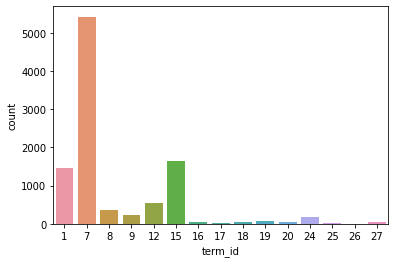

In [15]:
sns.countplot(df.term_id)

In [16]:
df.term_name.value_counts()

Discoteche & Party     5421
Aperitivo              1637
Uncategorized          1471
Magic The Gathering     534
Cena con Delitto        370
Latino Americano        227
Arte                    183
Carnevale                64
San Valentino            51
Teatro                   49
Fotografia               48
Halloween                42
Capodanno                26
Make Up                  12
Ferragosto                2
Name: term_name, dtype: int64

### Text cleaning

In [17]:
from text import PreProcessing

In [18]:
df["cleaned_desc"] = df["description"].progress_apply(PreProcessing.cleanText)

100%|██████████| 10137/10137 [00:25<00:00, 397.89it/s]


In [19]:
df["cleaned_title"] = df["title"].progress_apply(PreProcessing.cleanText)

100%|██████████| 10137/10137 [00:06<00:00, 1524.03it/s]


In [20]:
df["full_cleaned"] = df["cleaned_desc"] + df["cleaned_title"]

In [21]:
df = df.reset_index()

In [22]:
# We consider events equal if they have the same id and title
df = df.astype({"user": str, "place_id": str})

join_func = lambda col: ', '.join(col)

In [23]:
df_merged = pd.DataFrame(df.groupby(['ID', 'cleaned_title'], as_index=False).agg({
    'term_name': join_func,
    'place_id': join_func,
    'cleaned_desc' : join_func,
    'full_cleaned' : join_func,
    'user' : join_func}))

In [24]:
df_merged["full_cleaned"] = df_merged["full_cleaned"].progress_apply(lambda x: ' '.join(set(x.strip().split(", "))))
df_merged["cleaned_desc"] = df_merged["cleaned_desc"].progress_apply(lambda x: ' '.join(set(x.strip().split(", "))))
df_merged['user'] = df_merged['user'].progress_apply(lambda x: ', '.join(set(x.strip().split(", "))))
df_merged['term_name'] = df_merged['term_name'].progress_apply(lambda x: set(x.strip().split(", ")))
df_merged['place_id'] = df_merged['place_id'].progress_apply(lambda x: ', '.join(set(x.strip().split(", "))))

100%|██████████| 8971/8971 [00:00<00:00, 658357.41it/s]


In [25]:
df_merged.head()

,ID,cleaned_title,term_name,place_id,cleaned_desc,full_cleaned,user
0,1048,giovedi take away largo cairoli noche tropical,{Latino Americano},90930,giovedi serata noche tropical take away largo ...,giovedi serata noche tropical take away largo ...,1
1,1124,ott arianna antinori hostaria cohen release party,{Uncategorized},91136,ingresso gratuito invito richiedilo scrivendo ...,ingresso gratuito invito richiedilo scrivendo ...,1
2,1367,anathema alcest milano,{Uncategorized},91136,anathema nuovo album data italiana piacere ann...,anathema nuovo album data italiana piacere ann...,1
3,1370,love haiducii milano sab ottobre alcatraz,{Discoteche & Party},91136,love xxl alcatraz milano sabato ottobre specia...,love xxl alcatraz milano sabato ottobre specia...,1
4,1374,fabri fibra ottobre milano alcatraz,{Uncategorized},91136,fabri fibra fenomeno tour ottobre alcatraz mil...,fabri fibra fenomeno tour ottobre alcatraz mil...,1


### One-hot encoding and vectorization of text

In [26]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_merged.term_name)
y[126]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [27]:
with open('df_merged.pk', 'wb') as file:
    pickle.dump(df_merged, file)
    
with open('y.pk', 'wb') as file:
    pickle.dump(y, file)

with open('labels_list.pk', 'wb') as file:
    pickle.dump(mlb.classes_, file)

In [13]:
df_onehot_place = pd.get_dummies(df_merged['place_id'], prefix='place_id', drop_first=True)
df_onehot_user = pd.get_dummies(df_merged['user'], prefix='user', drop_first=True)
df_onehot = df_onehot_place.join(df_onehot_user)

onehot_sparse = scipy.sparse.csr_matrix(df_onehot.values, dtype=np.int64)

del df_onehot_place, df_onehot_user, df_onehot, df

We'll want to try different representations:
1. BoW (descr + title)
2. BoW (descr + title) + place + user
3. Tfidf (descr + title)
4. Tfidf (descr + title) + place + user

In [14]:
vect_bow = CountVectorizer()
vect_tfidf = TfidfVectorizer()

In [15]:
X1 = vect_bow.fit_transform(df_merged['full_cleaned'])
X2 = scipy.sparse.hstack([X1, onehot_sparse], dtype=np.int64, format="csr")
X3 = vect_tfidf.fit_transform(df_merged['full_cleaned'])
X4 = scipy.sparse.hstack([X3, onehot_sparse], dtype=np.int64, format="csr")

In [31]:
with open('bow_vectorizer.pk', 'wb') as vect:
    pickle.dump(vect_bow, vect)

with open('X2.pk', 'wb') as file:
    pickle.dump(X2, file)
    
with open('tfidf_vectorizer.pk', 'wb') as vect:
    pickle.dump(vect_tfidf, vect)

with open('X3.pk', 'wb') as file:
    pickle.dump(X3, file)

## Experiments

### Random Forest

In [32]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X2, y, test_size = 0.3)

In [33]:
clf = RandomForestClassifier(verbose = 10, n_jobs=-1, random_state=123)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s


building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.4s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100building tree 59 of 100

building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.1s


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.1s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 88 of 100

building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.1s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=10,
                       warm_start=False)

In [34]:
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)

In [35]:
precision_score(y_train, y_hat_train, average='micro'), precision_score(y_test, y_hat_test, average='micro')

(0.9915397631133672, 0.9361928394186458)

In [36]:
recall_score(y_train, y_hat_train, average='micro'), recall_score(y_test, y_hat_test, average='micro')

(0.9908412005072565, 0.86875)

In [37]:
f1_score(y_train, y_hat_train, average='micro'), f1_score(y_test, y_hat_test, average='micro')

(0.9911903587285926, 0.9012113973724621)

In [38]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       491
           1       1.00      0.51      0.67        55
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        21
           4       0.98      0.90      0.94       111
           5       0.98      0.95      0.96      1626
           6       0.00      0.00      0.00         0
           7       1.00      0.43      0.60        14
           8       0.00      0.00      0.00        12
           9       0.92      0.66      0.77        68
          10       0.96      0.98      0.97       160
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        15
          13       1.00      0.20      0.33        15
          14       0.84      0.91      0.87       441

   micro avg       0.94      0.87      0.90      3040
   macro avg       0.57      0.42      0.46      3040
weighted avg       0.92   

/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
print(multilabel_confusion_matrix(y_test, y_hat_test))

[[[2139   58]
  [ 129  362]]

 [[2633    0]
  [  27   28]]

 [[2681    0]
  [   7    0]]

 [[2665    2]
  [  21    0]]

 [[2575    2]
  [  11  100]]

 [[1031   31]
  [  87 1539]]

 [[2688    0]
  [   0    0]]

 [[2674    0]
  [   8    6]]

 [[2676    0]
  [  12    0]]

 [[2616    4]
  [  23   45]]

 [[2522    6]
  [   3  157]]

 [[2684    0]
  [   4    0]]

 [[2673    0]
  [  15    0]]

 [[2673    0]
  [  12    3]]

 [[2170   77]
  [  40  401]]]


In [40]:
param_grid = [{'n_estimators':[100,200,300,500], 
               'max_depth':[50,100], 'min_samples_leaf':[5,10,50],
              'min_samples_split':[5,10],
              'bootstrap':[True,False]}]

rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, cv = 5, verbose=10, n_jobs=-1, scoring='f1_micro')

clf.fit(X_train, y_train)

clf.best_params_, clf.best_score_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

({'bootstrap': False,
  'max_depth': 100,
  'min_samples_leaf': 5,
  'min_samples_split': 10,
  'n_estimators': 500},
 0.8105089517072536)

In [55]:
y_hat_test = clf.predict(X_test)

In [56]:
precision_score(y_test, y_hat_test, average='micro')

0.8901062416998672

In [57]:
recall_score(y_test, y_hat_test, average='micro')

0.8819078947368421

In [58]:
f1_score(y_test, y_hat_test, average='micro')

0.8859881031064111

### KNN

In [59]:
clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [60]:
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

In [61]:
precision_score(y_train, y_hat_train, average='micro'), precision_score(y_test, y_hat_test, average='micro')

(0.9337613072658302, 0.8652653342522398)

In [62]:
recall_score(y_train, y_hat_train, average='micro'), recall_score(y_test, y_hat_test, average='micro')

(0.9017894885162745, 0.8259868421052632)

In [63]:
f1_score(y_train, y_hat_train, average='micro'), f1_score(y_test, y_hat_test, average='micro')

(0.9174969536233962, 0.8451699764389096)

In [64]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       491
           1       1.00      0.42      0.59        55
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        21
           4       0.98      0.74      0.84       111
           5       0.96      0.90      0.93      1626
           6       0.00      0.00      0.00         0
           7       1.00      0.29      0.44        14
           8       1.00      0.08      0.15        12
           9       0.82      0.68      0.74        68
          10       0.89      0.95      0.92       160
          11       0.00      0.00      0.00         4
          12       1.00      0.07      0.12        15
          13       1.00      0.33      0.50        15
          14       0.66      0.90      0.76       441

   micro avg       0.87      0.83      0.85      3040
   macro avg       0.67      0.40      0.45      3040
weighted avg       0.87   

/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
print(multilabel_confusion_matrix(y_test, y_hat_test))

[[[2098   99]
  [ 157  334]]

 [[2633    0]
  [  32   23]]

 [[2681    0]
  [   7    0]]

 [[2667    0]
  [  21    0]]

 [[2575    2]
  [  29   82]]

 [[1006   56]
  [ 161 1465]]

 [[2688    0]
  [   0    0]]

 [[2674    0]
  [  10    4]]

 [[2676    0]
  [  11    1]]

 [[2610   10]
  [  22   46]]

 [[2510   18]
  [   8  152]]

 [[2684    0]
  [   4    0]]

 [[2673    0]
  [  14    1]]

 [[2673    0]
  [  10    5]]

 [[2041  206]
  [  43  398]]]


In [66]:
param_grid = [{"n_neighbors": range(1,21)}]

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid, cv = 5, verbose=10, n_jobs=-1, scoring='f1_micro')

clf.fit(X_train, y_train)

clf.best_params_, clf.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   24.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished


({'n_neighbors': 1}, 0.7929703349941822)

In [67]:
y_hat_test = clf.predict(X_test)

In [68]:
f1_score(y_test, y_hat_test, average='micro')

0.8859881031064111

### Neural Network

In [ ]:
tf.__version__

'2.2.0-rc3'

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17740025158728597866, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6601586473274676401
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17166799390621081162
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15794637764607165208
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [ ]:
!cat /proc/meminfo

MemTotal:       26751700 kB
MemFree:        19649836 kB
MemAvailable:   25042452 kB
Buffers:          102364 kB
Cached:          5334452 kB
SwapCached:            0 kB
Active:          1946016 kB
Inactive:        4643188 kB
Active(anon):     992192 kB
Inactive(anon):     2384 kB
Active(file):     953824 kB
Inactive(file):  4640804 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1792 kB
Writeback:             0 kB
AnonPages:       1152356 kB
Mapped:           705140 kB
Shmem:              2984 kB
Slab:             282176 kB
SReclaimable:     211908 kB
SUnreclaim:        70268 kB
KernelStack:        5112 kB
PageTables:        10668 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13375848 kB
Committed_AS:    4049372 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1920 kB
AnonHugePages:   

In [ ]:
batch_size = 64

def batch_generator(X, y, batch_size):
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index,:]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch,:]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

def compute_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience = 2, min_delta=0.01)

In [ ]:
def get_model(input_dim):
    with tf.device('/device:GPU:0'):
        model = Sequential()
        model.add(Dense(1024, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(len(mlb.classes_), activation='sigmoid'))
        
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', compute_f1])
    
    return model

In [ ]:
model = get_model(X_train.shape[1])

In [ ]:
model.summary()

In [ ]:
history = model.fit(x=batch_generator(X_train, y_train, batch_size),
                    epochs=20,
                    callbacks=[es],
                    steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                    #class_weight=class_weights,
                    use_multiprocessing=False)

Epoch 1/20
99/99 [==============================] - 2s 24ms/step - loss: 1.2573 - accuracy: 0.5177 - compute_f1: 0.6369
Epoch 2/20
99/99 [==============================] - 2s 24ms/step - loss: 0.5884 - accuracy: 0.7979 - compute_f1: 0.8599
Epoch 3/20
99/99 [==============================] - 2s 24ms/step - loss: 0.4147 - accuracy: 0.8698 - compute_f1: 0.9189
Epoch 4/20
99/99 [==============================] - 2s 24ms/step - loss: 0.3672 - accuracy: 0.8822 - compute_f1: 0.9361
Epoch 5/20
99/99 [==============================] - 2s 24ms/step - loss: 0.3325 - accuracy: 0.8759 - compute_f1: 0.9388
Epoch 6/20
99/99 [==============================] - 2s 24ms/step - loss: 0.3142 - accuracy: 0.8665 - compute_f1: 0.9465
Epoch 7/20
99/99 [==============================] - 2s 24ms/step - loss: 0.2961 - accuracy: 0.8767 - compute_f1: 0.9543
Epoch 8/20
99/99 [==============================] - 2s 24ms/step - loss: 0.2847 - accuracy: 0.8916 - compute_f1: 0.9569
Epoch 9/20
99/99 [======================

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/whatsout/model_nn.h5")

In [ ]:
history.history['compute_f1'][-1]

0.9581371545791626

In [ ]:
model = tensorflow.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/whatsout/model_nn.h5", custom_objects={"compute_f1": compute_f1})

In [ ]:
score = model.evaluate(x=batch_generator(X_test, y_test, batch_size), verbose=1,
                       steps=np.ceil(X_test.shape[0]/batch_size),
                       use_multiprocessing=False)

42/42 [==============================] - 1s 13ms/step - loss: 0.5748 - accuracy: 0.8211 - compute_f1: 0.9131


In [ ]:
print("Test F1 score:", score[2])

Test F1 score: 0.9130619764328003


In [ ]:
folds = MultilabelStratifiedKFold(n_splits=5, random_state=123, shuffle=True)
cvscores = []

for i, (train, val) in enumerate(folds.split(X2, y)):
    print('\nFold',str(i),'\n')
    model = get_model(X2.shape[1])
    history = model.fit(x=batch_generator(X2[train], y[train], batch_size),
                    epochs=20,
                    callbacks=[es],
                    steps_per_epoch=np.ceil(X2[train].shape[0]/batch_size),
                    #class_weight='balanced',
                    use_multiprocessing=False)
    
    scores = model.evaluate(x=batch_generator(X2[val], y[val], batch_size), verbose=1,
                            steps=np.ceil(X2[val].shape[0]/batch_size),
                            use_multiprocessing=False)
    
    cvscores.append(scores[1])


Fold 0 

Epoch 1/20
112/112 [==============================] - 3s 25ms/step - loss: 1.0142 - accuracy: 0.6619 - compute_f1: 0.7329
Epoch 2/20
112/112 [==============================] - 3s 25ms/step - loss: 0.4502 - accuracy: 0.8330 - compute_f1: 0.8991
Epoch 3/20
112/112 [==============================] - 3s 25ms/step - loss: 0.3559 - accuracy: 0.8686 - compute_f1: 0.9256
Epoch 4/20
112/112 [==============================] - 3s 24ms/step - loss: 0.3299 - accuracy: 0.9044 - compute_f1: 0.9337
Epoch 5/20
112/112 [==============================] - 3s 24ms/step - loss: 0.2990 - accuracy: 0.9005 - compute_f1: 0.9433
Epoch 6/20
112/112 [==============================] - 3s 24ms/step - loss: 0.2802 - accuracy: 0.8936 - compute_f1: 0.9538
Epoch 7/20
112/112 [==============================] - 3s 24ms/step - loss: 0.2773 - accuracy: 0.8732 - compute_f1: 0.9562
Epoch 8/20
112/112 [==============================] - 3s 24ms/step - loss: 0.2779 - accuracy: 0.8979 - compute_f1: 0.9543
Epoch 00008: e

In [ ]:
print(np.mean(cvscores))

0.8050758957862854


### Classifier Chain

In [ ]:
def CC_problem(train, lbl_train, test, lbl_test, save_model = False):
    clf = ClassifierChain(
        classifier = SGDClassifier(n_jobs=-1, class_weight='balanced', random_state=123),
        require_dense = [False, True])
    
    clf.fit(train, lbl_train)

    if save_model:
        with open('/content/drive/My Drive/Colab Notebooks/whatsout/model_svm.pk', 'wb') as file:
            pickle.dump(clf, file)
    
    return f1_score(lbl_train, clf.predict(train), average='micro'), f1_score(lbl_test, clf.predict(test), average='micro')

In [ ]:
print(CC_problem(X_train, y_train, X_test, y_test, True))

(0.8866060328469542, 0.8112033195020747)


In [ ]:
def multilabel_random_oversample(X, y):
    lp = LabelPowerset()
    ros = RandomOverSampler(random_state=42)

    yt = lp.transform(y)

    X_resampled, y_resampled = ros.fit_sample(X, yt)

    y_resampled = lp.inverse_transform(y_resampled)
    
    return X_resampled, y_resampled

In [ ]:
X_resampled, y_resampled = multilabel_random_oversample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(CC_problem(X_resampled, y_resampled, X_test, y_test))

(0.9977242357027057, 0.8786145535430568)


In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.69      0.73       491
           1       1.00      0.42      0.59        55
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        21
           4       0.98      0.74      0.84       111
           5       0.97      0.90      0.93      1626
           6       0.00      0.00      0.00         0
           7       1.00      0.29      0.44        14
           8       1.00      0.08      0.15        12
           9       0.85      0.69      0.76        68
          10       0.89      0.96      0.92       160
          11       0.00      0.00      0.00         4
          12       1.00      0.13      0.24        15
          13       1.00      0.33      0.50        15
          14       0.66      0.90      0.76       441

   micro avg       0.87      0.83      0.85      3040
   macro avg       0.67      0.41      0.46      3040
weighted avg       0.88   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(multilabel_confusion_matrix(y_test, clf.predict(X_test)))

[[[2091  106]
  [ 151  340]]

 [[2633    0]
  [  32   23]]

 [[2681    0]
  [   7    0]]

 [[2667    0]
  [  21    0]]

 [[2575    2]
  [  29   82]]

 [[1012   50]
  [ 165 1461]]

 [[2688    0]
  [   0    0]]

 [[2674    0]
  [  10    4]]

 [[2676    0]
  [  11    1]]

 [[2612    8]
  [  21   47]]

 [[2510   18]
  [   7  153]]

 [[2684    0]
  [   4    0]]

 [[2673    0]
  [  13    2]]

 [[2673    0]
  [  10    5]]

 [[2047  200]
  [  44  397]]]


### Full training with CV on every dataset

In [ ]:
# Run everything on every dataset

datasets = [X1, X2, X3, X4]
knn_test_scores = []
rf_test_scores = []
nn_test_scores = []
cc_test_scores = []

def training_func(X, y, i, isOver=False):
    # ClassifierChain SVM
    print("\nSVM for dataset ", str(i))
    folds = MultilabelStratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    cc_test_score, knn_score = [], []
    for j, (train, val) in enumerate(folds.split(X, y)):
        cc = ClassifierChain(
            classifier = SGDClassifier(n_jobs=-1, class_weight='balanced', random_state=123),
            require_dense = [False, True])
        
        cc.fit(X[train], y[train])
        cc_test_score.append(f1_score(y[val], cc.predict(X[val]), average='micro'))

    cc_test_scores.append(np.mean(cc_test_score))

    # KNN
    print("\nKNN for dataset ", str(i))
    knn_score = cross_val_score(KNeighborsClassifier(n_jobs=-1), X, y, n_jobs=-1, scoring='f1_micro')
    knn_test_scores.append(np.mean(knn_score))

    # Random Forest
    print("\nRandom forest for dataset ", str(i))
    score = cross_val_score(RandomForestClassifier(n_jobs=-1, random_state=123), X, y, n_jobs=-1, scoring='f1_micro')
    rf_test_scores.append(np.mean(score))

    # Neural Network
    print("\nNN for dataset ", str(i))
    cvscores_test = []
    for i, (train, val) in enumerate(folds.split(X, y)):
        print('\nFold',str(i),'\n')
        model = get_model(data.shape[1])
        history = model.fit(x=batch_generator(X[train], y[train], batch_size),
                            epochs=20,
                            callbacks=[es],
                            steps_per_epoch=np.ceil(X[train].shape[0]/batch_size),
                            verbose=0,
                            use_multiprocessing=False)
    
        scores = model.evaluate(x=batch_generator(X[val], y[val], batch_size), verbose=0,
                                steps=np.ceil(X[val].shape[0]/batch_size),
                                use_multiprocessing=False)
        cvscores_test.append(scores[1])
    
    nn_test_scores.append(np.mean(cvscores_test))

In [ ]:
# TRAINING
for i, data in enumerate(datasets):
    print("\nDataset: ", str(i))

    # Train
    training_func(data, y, i)


Dataset:  0

SVM for dataset  0

KNN for dataset  0

Random forest for dataset  0

NN for dataset  0

Fold 0 

Epoch 00009: early stopping

Fold 1 

Epoch 00007: early stopping

Fold 2 

Epoch 00012: early stopping

Fold 3 

Epoch 00008: early stopping

Fold 4 

Epoch 00011: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Dataset:  1

SVM for dataset  1

KNN for dataset  1


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Random forest for dataset  1

NN for dataset  1

Fold 0 

Epoch 00012: early stopping

Fold 1 

Epoch 00009: early stopping

Fold 2 

Epoch 00010: early stopping

Fold 3 

Epoch 00011: early stopping

Fold 4 

Epoch 00009: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Dataset:  2

SVM for dataset  2

KNN for dataset  2

Random forest for dataset  2

NN for dataset  2

Fold 0 

Epoch 00012: early stopping

Fold 1 

Epoch 00013: early stopping

Fold 2 

Epoch 00013: early stopping

Fold 3 

Epoch 00015: early stopping

Fold 4 

Epoch 00013: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Dataset:  3

SVM for dataset  3

KNN for dataset  3


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Random forest for dataset  3

NN for dataset  3

Fold 0 

Epoch 00014: early stopping

Fold 1 

Epoch 00012: early stopping

Fold 2 

Epoch 00011: early stopping

Fold 3 

Epoch 00012: early stopping

Fold 4 

Epoch 00012: early stopping


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Matrix Regression (MR)

Reference paper: https://www.researchgate.net/publication/4257876_Text_Categorization_for_Multi-label_Documents_and_Many_Categories

In [2]:
# Load everything back.
with open('df_merged.pk', 'rb') as file:
    df_merged = pickle.load(file)
    
with open('y.pk', 'rb') as file:
    y = pickle.load(file)
    
with open('labels_list.pk', 'rb') as file:
    labels_list = pickle.load(file)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_merged['full_cleaned'].values, y, test_size = 0.3)

In [5]:
from matrix_regression.matrixregression import MatrixRegression

In [5]:
mr = MatrixRegression()

In [6]:
mr.fit(X_train, y_train)

MatrixRegression(n_jobs=1, threshold=None)

In [7]:
y_hat_train_mr = mr.predict(X_train)

In [8]:
y_hat_test_mr = mr.predict(X_test)

In [9]:
precision_score(y_train, y_hat_train_mr, average='micro'), precision_score(y_test, y_hat_test_mr, average='micro')

(0.14022085368443407, 0.133382862803368)

In [10]:
recall_score(y_train, y_hat_train_mr, average='micro'), recall_score(y_test, y_hat_test_mr, average='micro')

(0.9294763513513513, 0.8878997692054071)

In [11]:
f1_score(y_train, y_hat_train_mr, average='micro'), f1_score(y_test, y_hat_test_mr, average='micro')

(0.2436801121895413, 0.23192524652284374)

In [12]:
print(classification_report(y_test, y_hat_test_mr))

              precision    recall  f1-score   support

           0       0.23      0.89      0.37       493
           1       0.06      0.78      0.11        60
           2       0.00      0.71      0.01         7
           3       0.01      0.70      0.01        20
           4       0.16      0.98      0.28       103
           5       0.85      0.95      0.90      1615
           6       0.00      0.00      0.00         0
           7       0.04      0.83      0.08        12
           8       0.00      0.58      0.01        12
           9       0.03      0.78      0.05        64
          10       0.57      0.87      0.69       171
          11       0.00      0.00      0.00         0
          12       0.01      1.00      0.02        17
          13       0.04      0.75      0.07        16
          14       0.13      0.70      0.22       443

   micro avg       0.13      0.89      0.23      3033
   macro avg       0.14      0.70      0.19      3033
weighted avg       0.55   

/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print(multilabel_confusion_matrix(y_test, y_hat_test_mr))

[[[ 768 1431]
  [  54  439]]

 [[1868  764]
  [  13   47]]

 [[1014 1671]
  [   2    5]]

 [[ 715 1957]
  [   6   14]]

 [[2061  528]
  [   2  101]]

 [[ 799  278]
  [  81 1534]]

 [[1242 1450]
  [   0    0]]

 [[2440  240]
  [   2   10]]

 [[ 885 1795]
  [   5    7]]

 [[ 884 1744]
  [  14   50]]

 [[2409  112]
  [  23  148]]

 [[ 914 1778]
  [   0    0]]

 [[1223 1452]
  [   0   17]]

 [[2376  300]
  [   4   12]]

 [[ 252 1997]
  [ 134  309]]]


In [14]:
param_grid = [{"threshold": [0.7, 0.75, 0.8, 0.85, 0.9]}]

mr = MatrixRegression()
clf = GridSearchCV(mr, param_grid, cv = 5, verbose=10, n_jobs=-1, scoring='f1_micro')

clf.fit(X_train, y_train)

clf.best_params_, clf.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  2.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  2.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  3.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  3.6min remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.8min finished


({'threshold': 0.75}, 0.44857382045910865)

In [15]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.44964616222101245

Let's test partial fit now. Some random new text with a word that is not present in the corpus (i.e.: bungie).
`y` will contain one new category, that is we'll go to 16 labels

In [7]:
new_X = np.array(["Ciao questo prova nuovo testo", "prova testo numero", "bungie testo parola sicuro niente"])
new_y = np.zeros((3,16), dtype=int)

In [8]:
new_y[0,[2,5]] = 1
new_y[1,[3,9,15]] = 1
new_y[2,1] = 1

In [9]:
new_y

array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [10]:
"bungie" in mr.terms

False

In [11]:
mr.W.shape

(29949, 15)

In [12]:
mr.partial_fit(new_X, new_y)

MatrixRegression(n_jobs=1, threshold=None)

In [13]:
mr.W.shape

(29951, 16)

The shape has changed. New terms and the new category we added.

In [14]:
"bungie" in mr.terms

True

In [ ]:
def get_size(X):
    if isinstance(X, np.ndarray):
        return np.round(X.nbytes/1e6, 2)
    elif isinstance(X, scipy.sparse.csr.csr_matrix):
        return np.round((X.data.nbytes + X.indptr.nbytes + X.indices.nbytes)/1e6, 2)
    else:
        raise NotImplementedError('We still cannot calculate the size for this type')

## Results

In [ ]:
dataset_names = ['BoW (descr + title)', 'BoW (descr + title) + place + user','Tfidf (descr + title)','Tfidf (descr + title) + place + user']

In [ ]:
results_test = pd.DataFrame(list(zip(dataset_names, knn_test_scores, rf_test_scores, nn_test_scores, cc_test_scores)),
                       columns =['Dataset','KNN', 'Random Forest', 'Neural Network', 'SVM']) 

print('Cross-validated F1 score:\n')
results_test

Cross-validated F1 score:



,Dataset,KNN,Random Forest,Neural Network,SVM
0,BoW (descr + title),0.788153,0.823445,0.848590,0.819440
1,BoW (descr + title) + place + user,0.795606,0.825124,0.840044,0.819511
2,Tfidf (descr + title),0.817052,0.831930,0.827103,0.865096
3,Tfidf (descr + title) + place + user,0.704854,0.758021,0.734499,0.615040


In [ ]:
results_test.to_csv('/content/drive/My Drive/Colab Notebooks/whatsout/results_cv.csv')